<h2 align="center">Codebasics DL Course: Data Augmentation</h2>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [5]:
batch_size = 100

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


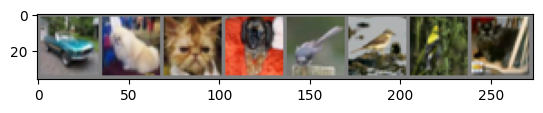

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images[:8]))

In [8]:
labels[:8]

tensor([1, 5, 3, 5, 2, 2, 2, 3])

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

[classes[i] for i in labels[:8]]

['car', 'dog', 'cat', 'dog', 'bird', 'bird', 'bird', 'cat']

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), padding='same'),  # Output: (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),        # Output: (32, 16, 16)
            
            nn.Conv2d(32, 64, kernel_size=(3,3)),             # Output: (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))         # Output: (64, 7, 7)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                # Flatten to (64 * 7 * 7 = 3136)
            nn.Linear(64 * 7 * 7, 600),                  # Corrected input size
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )
        
    def forward(self, x):
        x = self.network(x)
        x = self.fc_layers(x)
        return x

In [23]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    train_losses, val_losses, val_accuracy = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_losses.append(val_loss / len(val_loader))
        val_accuracy.append(correct/total)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy:  {100 * val_accuracy[-1]:.2f}%")
        
    return train_losses, val_losses, val_accuracy

In [24]:
# Hyperparameters
num_epochs = 5
learning_rate = 0.001

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train without augmentation
train_losses, val_losses, val_accuracy = train_model(model, criterion, optimizer, train_loader, test_loader, epochs=5)

Epoch 1/5, Train Loss: 1.3905, Val Loss: 1.1179, Val Accuracy:  60.59%
Epoch 2/5, Train Loss: 0.9857, Val Loss: 0.9764, Val Accuracy:  65.41%
Epoch 3/5, Train Loss: 0.7951, Val Loss: 0.8765, Val Accuracy:  69.45%
Epoch 4/5, Train Loss: 0.6315, Val Loss: 0.8578, Val Accuracy:  70.86%
Epoch 5/5, Train Loss: 0.4897, Val Loss: 0.8154, Val Accuracy:  73.03%


### With Data Augmentation

In [25]:
# import torchvision.transforms as transforms

transform_with_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_with_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True)

model_aug = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=learning_rate)

train_losses, val_losses, val_accuracy = train_model(model_aug, criterion, optimizer, train_loader_aug, test_loader, epochs=5)

Files already downloaded and verified
Epoch 1/5, Train Loss: 1.4006, Val Loss: 1.0702, Val Accuracy:  61.66%
Epoch 2/5, Train Loss: 1.0301, Val Loss: 0.9303, Val Accuracy:  67.15%
Epoch 3/5, Train Loss: 0.8922, Val Loss: 0.8155, Val Accuracy:  71.46%
Epoch 4/5, Train Loss: 0.8071, Val Loss: 0.7839, Val Accuracy:  72.75%
Epoch 5/5, Train Loss: 0.7451, Val Loss: 0.8453, Val Accuracy:  70.95%
